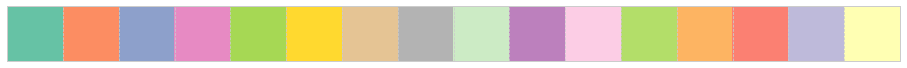

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd 
import openpyxl
import numpy as np
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt
import re
from collections import deque, defaultdict
import collections
from unicodedata import normalize
import itertools
import seaborn as sns
# graph setting
%matplotlib inline
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_context("paper", 1.5, {"lines.linewidth": 1.5})
sns.set_palette("Set2")
current_palette = list(sns.color_palette("Set2", n_colors=8) + sns.color_palette("Set3_r", n_colors=8))
sns.set_palette(current_palette)
sns.palplot(current_palette)
matplotlib.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'IPAexGothic'
plt.style.use('seaborn')
import japanize_matplotlib

In [2]:
curr_dir = os.path.realpath('.')

In [3]:
datapath = os.path.join(curr_dir, "data" ,"seg_data")

In [4]:
filename = os.path.join(datapath, "生活価値観セグメントデータ221207.xlsx")

In [5]:
layout_df = pd.read_excel(filename, sheet_name="レイアウト", skiprows=0)

In [6]:
len(layout_df.columns)

207

In [7]:
def get_new_layout_columns():
    alphabet = [chr(ord("A") + i) for i in range(26)]
    def recurse(s):
        return [s + a for a in alphabet]
    
    res = deepcopy(alphabet)
    for a in alphabet:
        res.extend(recurse(a))
        if len(res) > len(layout_df.columns):
            return res[0:len(layout_df.columns)]

                


In [8]:
columns = get_new_layout_columns()

In [9]:
layout_df = layout_df.shift(1)
layout_df.loc[0] = layout_df.columns
layout_df.rename(columns=dict(zip(layout_df.columns, columns)), inplace=True)

In [10]:
'トヨタ / プリウス(ハイブリッド)', 'ホンダ / フィット',

('トヨタ / プリウス(ハイブリッド)', 'ホンダ / フィット')

In [11]:
def get_car_by_year(df, year):
    data = {2022: slice(4, 7),
            2017: slice(24, 27),
            2012: slice(42, 46),
           }
    car_df = layout_df.iloc[data[year], 7:].values.reshape(-1)
    return car_df
    


In [12]:
def retrieve_car(x):
    if chr(42) in x:
        return ""
    res = x.split(",")
    for el in res:
        if el:
            return el
    return ""
    
def get_df_by_year(layout_df, year):
    car_df = get_car_by_year(layout_df, year)
    car_df = pd.DataFrame(car_df, columns=["car_and_engine"])
    car_df = car_df[~pd.isna(car_df["car_and_engine"])]
    car_df["hybrid"] = car_df["car_and_engine"].apply(lambda x: "(ハイブリッド)" in x)
    car_df["car_brand"] = car_df["car_and_engine"].apply(lambda x: x.split(" / ")[0])
    car_df["car_name"] = car_df["car_and_engine"].apply(lambda x: " / ".join(x.split(" / ")[1:]).replace("(ハイブリッド)", "").
                                                        replace("(プラグインハイブリッド)", ""))#.replace("(電気自動車)", ""))
    sheets = {2022: "2022_35th_rawdata(セグメント付与済)",
              2017: "2017_25th_rawdata(セグメント付与済)",
              2012: "2012_16th_rawdata(セグメント付与済)"
             }
    df = pd.read_excel(filename, sheet_name=sheets[year])
    car_answer_col = {2022: "Nq66-68_2", 2017: "Nq66-68", 2012: "Nq66"}[year]
    df["car_answer"] = df[car_answer_col].apply(retrieve_car)
    df["car_brand"] = df["car_answer"].apply(lambda x: car_df.loc[int(x)-1, "car_brand"] if x else "")
    df["car_name"] = df["car_answer"].apply(lambda x: car_df.loc[int(x)-1, "car_name"] if x else "")
    df["hybrid"] = df["car_answer"].apply(lambda x: car_df.loc[int(x)-1, "hybrid"] if x else "")
    df["year"] = year
    age_col = {2022: "AGE",
              2017: "age",
              2012: "AGE(N)"}[year]
    cols = ["year", age_col,"cl",'car_answer', 'car_brand', 'car_name', 'hybrid']
    df = df[cols].rename(columns={age_col: "age"})
    return df
# car_df = get_df_by_year(layout_df, 2012)

In [13]:
df = pd.concat([get_df_by_year(layout_df, year) for year in [2022, 2017, 2012]])

In [14]:
df = df.reset_index(drop=True)

1. How many peoples each segment have . Ex/ 「2012年のセグメント1は200人」

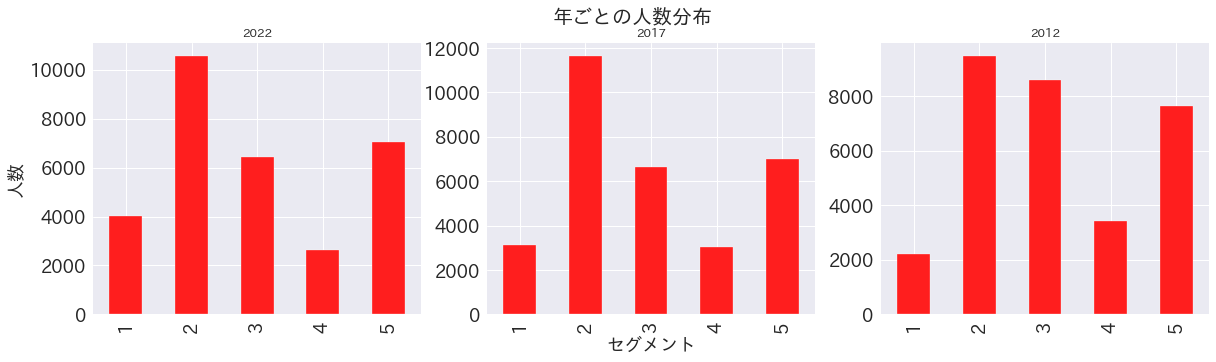

In [22]:
res = []
years = [2022, 2017, 2012]
fig, axes = plt.subplots(1, 3, figsize=(20,5),)
plt.suptitle("年ごとの人数分布", fontsize=20)
for i, year in enumerate(years):
    ax = axes[i]
    _df = df[df["year"] == year].copy(deep=True)
    _df.loc[:, "people"] = 1
    _df: pd.DataFrame = _df.groupby(by=["cl"]).agg({"people": sum})
    _df.plot.bar(ax=ax, facecolor="#ff1e1e", xlabel="", ylabel="",  fontsize=18)
    if i == 0:
        ax.set_ylabel("人数",  fontsize=18)
    if i == 1:
        ax.set_xlabel("セグメント", fontsize=18)
    ax.legend().remove()
    ax.set_title(year)
    __df = _df.copy(deep=True)
    __df["年"] = year
    __df.rename(columns={"people": "人数"})
    res.append(__df)



In [27]:
fig.savefig(os.path.join(datapath, "年ごと人数ーセグメント分布.png"), fig=fig)

/tmp/ipykernel_6237/3046603514.py:1: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fig" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(os.path.join(datapath, "年ごと人数ーセグメント分布.png"), fig=fig)


In [26]:
pd.concat(res).reset_index().to_excel(os.path.join(datapath, "年ごと人数ーセグメント分布.xlsx"))

For each segment make histogram about age (bins = 5) ineach years. Ex/「2012年のセグメント1の人口分布のヒストグラムはこれ」

/tmp/ipykernel_6237/4081137840.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fig" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(os.path.join(datapath, f"{year}年セグメントごと人数ーAge分布.png"), fig=fig)


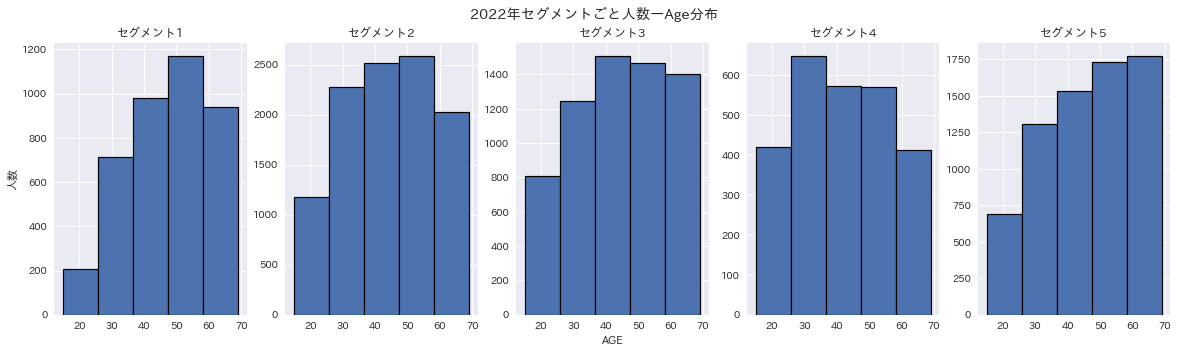

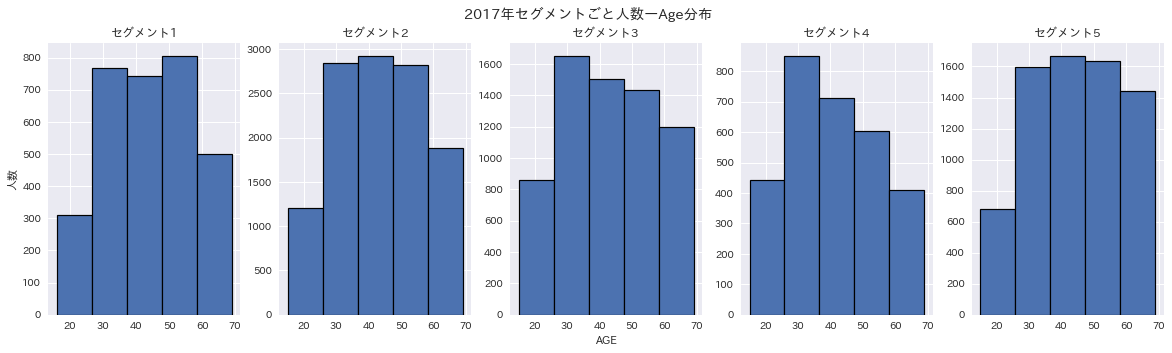

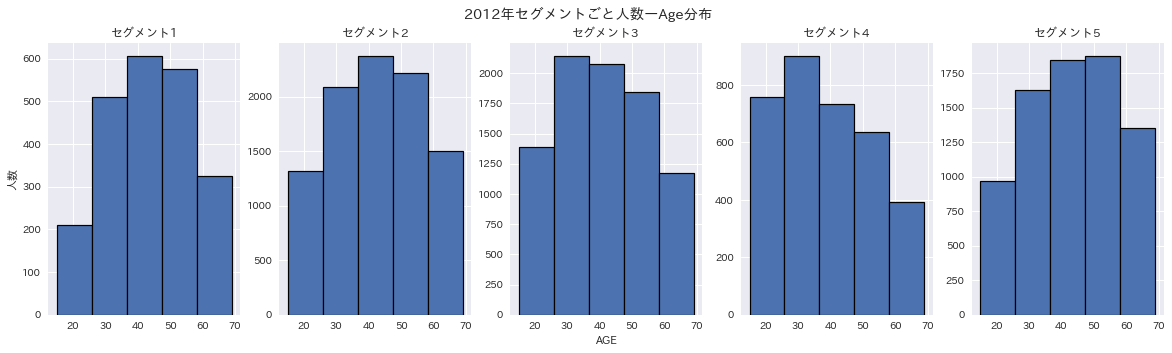

In [36]:

for i, year in enumerate(years):
    _df = df[df["year"] == year].copy(deep=True)
    fig, axes = plt.subplots(1, 5, figsize=(20,5))
    plt.suptitle(f"{year}年セグメントごと人数ーAge分布")
    
    for j, cl in enumerate(sorted(_df["cl"].unique())):
        ax = axes[j]
        x = _df[_df["cl"] == cl]["age"].values
        counts, bins = np.histogram(x)
        ax.hist(x, bins=5, edgecolor='black', linewidth=1.2)
        # if i == 0:
        ax.set_title(f"セグメント{cl}")
        if j == 2:
            ax.set_xlabel("AGE")
        if j == 0:
            ax.set_ylabel("人数")
            # ax.set_xlabel(f"Case {year}")
    fig.savefig(os.path.join(datapath, f"{year}年セグメントごと人数ーAge分布.png"), fig=fig)


In [33]:
df.to_excel(os.path.join(datapath, "セグメント処理データー.xlsx"))

In [185]:
df.to_excel(os.path.join(datapath, "compiled_df.xlsx"))

In [183]:
datapath

'/home/barry/projects/nexco/toyota/data/seg_data'

In [186]:
df

year  age  cl car_answer car_brand     car_name hybrid
0      2022   61   5                                         
1      2022   65   4        310       スバル         トレジア  False
2      2022   63   5        122      アウディ           A4  False
3      2022   45   2                                         
4      2022   64   5        318      プジョー          307  False
...     ...  ...  ..        ...       ...          ...    ...
93578  2012   44   3        216       ホンダ         フィット  False
93579  2012   20   3                                         
93580  2012   25   4        108       トヨタ  ランドクルーザープラド  False
93581  2012   21   3                                         
93582  2012   19   4                                         

[93583 rows x 7 columns]

In [195]:
start = 20
end = start + 40
pd.DataFrame(np.sort(df["car_name"].unique())[start:end])

0
0                   500 Pop
1                      500C
2                      500S
3                      500X
4                       508
5                     5シリーズ
6                     6シリーズ
7                     7シリーズ
8                        86
9                   911シリーズ
10                       A1
11                       A3
12                A3 e-tron
13                       A4
14                       A5
15                       A6
16                       A7
17                       A8
18               ABARTH 500
19  ABARTH 595 COMPETIZIONE
20       ABARTH 595 TURISMO
21      ABARTH 595C TURISMO
22       ABARTH 695 BIPOSTO
23                     ADバン
24                      AMG
25                 AZ-オフロード
26                   AZ-ワゴン
27           ActiveHybrid 3
28                     Aクラス
29               B3 BITURBO
30               B4 BITURBO
31               B6 BITURBO
32               B7 BITURBO
33                       BB
34                    BRERA
35                      BRZ
36                     Bクラス
37                     C-HR
38                       C3
39                      C30

In [196]:
df

year  age  cl car_answer car_brand     car_name hybrid
0      2022   61   5                                         
1      2022   65   4        310       スバル         トレジア  False
2      2022   63   5        122      アウディ           A4  False
3      2022   45   2                                         
4      2022   64   5        318      プジョー          307  False
...     ...  ...  ..        ...       ...          ...    ...
93578  2012   44   3        216       ホンダ         フィット  False
93579  2012   20   3                                         
93580  2012   25   4        108       トヨタ  ランドクルーザープラド  False
93581  2012   21   3                                         
93582  2012   19   4                                         

[93583 rows x 7 columns]

In [197]:
layout_df

A       B               C        D        E  \
0   2022.0  質問\n番号           アイテム名  回答\nタイプ  カテ\nゴリ数   
1      NaN     NaN        SAMPLEID       FA      NaN   
2      NaN     NaN              cl       SA        5   
3      NaN     q65             q65       SA        4   
4      NaN     NaN          q66-68       MA      591   
5      NaN     NaN             NaN      NaN      NaN   
6      NaN     NaN             NaN      NaN      NaN   
7      NaN     NaN             sex       SA        2   
8      NaN     NaN             age        N      NaN   
9      NaN    q310            q310       SA        2   
10     NaN    q311            q311       SA       47   
11     NaN    q312            q312       SA       12   
12     NaN     NaN        q153_1fa        N      NaN   
13     NaN     NaN        q156_1fa        N      NaN   
14     NaN    q157            q157       MA       11   
15     NaN     NaN        q158_1fa        N      NaN   
16     NaN     NaN        q159_1fa        N      NaN   
17     NaN    q163            q163       MA        6   
18     NaN     NaN             NaN      NaN      NaN   
19     NaN     NaN             NaN      NaN      NaN   
20     NaN     NaN             NaN      NaN      NaN   
21  2017.0  質問\n番号           アイテム名  回答\nタイプ  カテ\nゴリ数   
22     NaN     NaN        SAMPLEID        N      NaN   
23     NaN     q65             q65       SA        4   
24     NaN     NaN         Nq66-68       MA      585   
25     NaN     NaN             NaN      NaN      NaN   
26     NaN     NaN             NaN      NaN      NaN   
27     NaN     NaN             sex       SA        2   
28     NaN     NaN             age        N      NaN   
29     NaN    q310            q310       SA        2   
30     NaN    q311            q311       SA       47   
31     NaN    q312            q312       SA       12   
32     NaN    q153        q153_1fa        N      NaN   
33     NaN    q156        q156_1fa        N      NaN   
34     NaN    q157            q157       MA       11   
35     NaN    q158        q158_1fa        N      NaN   
36     NaN    q159        q159_1fa        N      NaN   
37     NaN    q163            q163       MA        6   
38     NaN     NaN             NaN      NaN      NaN   
39  2012.0  質問\n番号           アイテム名  回答\nタイプ  カテ\nゴリ数   
40     NaN     NaN        SAMPLEID        N      NaN   
41     NaN     q65             q65       SA        4   
42     NaN     NaN            Nq66       MA      501   
43     NaN     NaN             NaN      NaN      NaN   
44     NaN     NaN             NaN      NaN      NaN   
45     NaN     NaN         SEX(SA)       SA        2   
46     NaN     NaN          AGE(N)        N      NaN   
47     NaN     NaN  PREFECTURE(SA)       SA       47   
48     NaN     NaN     MARRIED(SA)       SA        2   
49     NaN     NaN         JOB(SA)       SA       11   
50     NaN    q153        q153_1fa        N      NaN   
51     NaN    q156        q156_1fa        N      NaN   
52     NaN    q157            q157       MA       11   
53     NaN    q158        q158_1fa        N      NaN   
54     NaN    q159        q159_1fa        N      NaN   

                                                    F  \
0                                                  表題   
1                                                 NaN   
2                                                 NaN   
3                         あなたが所有している「自動車」の台数を教えてください。   
4                        あなたが所有している「自動車の車種名」を教えてください。   
5                                                 NaN   
6                                                 NaN   
7                                                  性別   
8                                                  年齢   
9                                   あなたは現在ご結婚されていますか？   
10                        あなたが現在お住まいの都道府県についてお答えください。   
11                  あなたの職業について、以下の中からあてはまるものをお答えください。   
12                                あなたの「世帯年収」を教えてください。   
13  あなたの「世帯同居人数（自分を含めて）」を教えてください。※ご自分も含めて数えてください(一...   
14               

122

CO2共有用.xlsx

In [4]:
filename = os.path.join(datapath, 'CO2共有用.xlsx')

In [43]:
df = pd.read_excel(filename, )
df.rename(columns={'Unnamed: 0': 'year'}, inplace=True)

In [44]:
df

year  自家用乗用車CO2排出量(10^6t)  一人当たり実質GDP(10^6yen)  18歳以上74歳以下免許取得者(人)
0  2012                  107                4.059            77531202
1  2017                   94                4.358            77223088
2  2022                   84                4.310            76225259

In [45]:
df.columns
df = df[['year', '一人当たり実質GDP(10^6yen)',
       '18歳以上74歳以下免許取得者(人)', '自家用乗用車CO2排出量(10^6t)']]

一人当たり実質GDP(10^6yen) [4.059, 4.358, 4.31]
18歳以上74歳以下免許取得者(人) [77531202, 77223088, 76225259]
自家用乗用車CO2排出量(10^6t) [107, 94, 84]


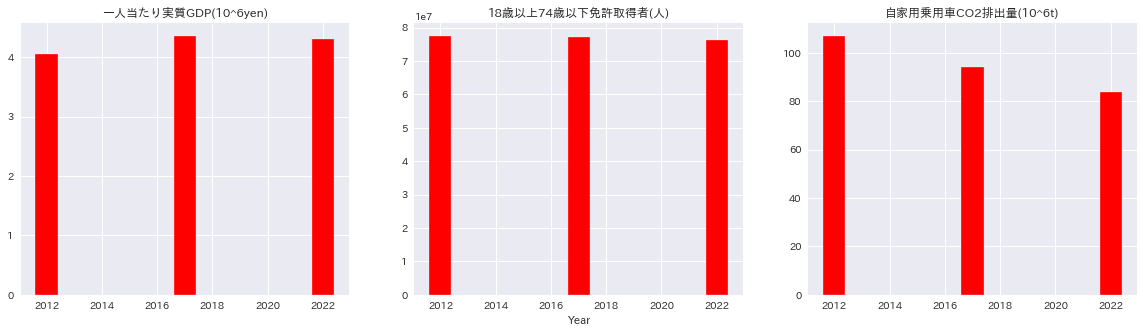

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
cols = df.columns[1:]
res = {col: [] for col in cols}
for i, year in enumerate(df['year']):
    for col in cols:
        res[col].append(df.loc[i, col])

for i, col in enumerate(cols):

    print(col, res[col])
    ax = axes[i]
    ax.bar(df["year"], res[col], facecolor='red')
    ax.set_title(col)
    if i == 1:
        ax.set_xlabel('Year')

In [51]:
list(itertools.permutations(cols.values, 2, ))

[('一人当たり実質GDP(10^6yen)', '18歳以上74歳以下免許取得者(人)'),
 ('一人当たり実質GDP(10^6yen)', '自家用乗用車CO2排出量(10^6t)'),
 ('18歳以上74歳以下免許取得者(人)', '一人当たり実質GDP(10^6yen)'),
 ('18歳以上74歳以下免許取得者(人)', '自家用乗用車CO2排出量(10^6t)'),
 ('自家用乗用車CO2排出量(10^6t)', '一人当たり実質GDP(10^6yen)'),
 ('自家用乗用車CO2排出量(10^6t)', '18歳以上74歳以下免許取得者(人)')]

In [48]:
df.columns

Index(['year', '一人当たり実質GDP(10^6yen)', '18歳以上74歳以下免許取得者(人)',
       '自家用乗用車CO2排出量(10^6t)'],
      dtype='object')

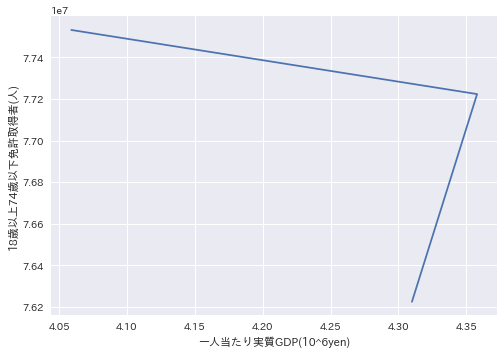

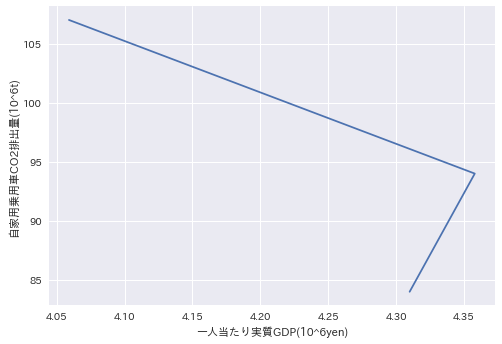

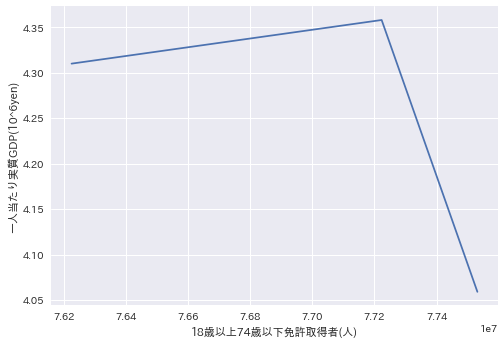

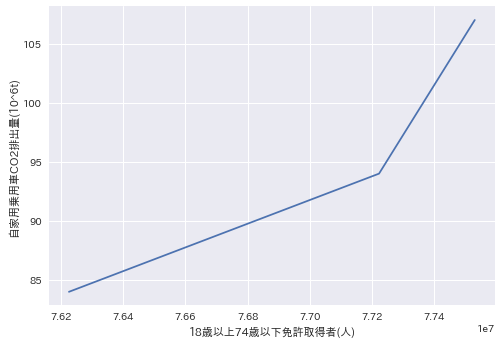

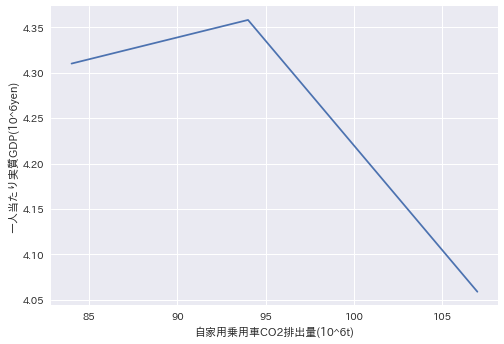

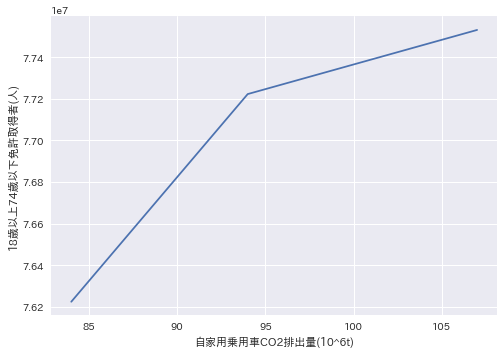

In [55]:

for col1, col2 in list(itertools.permutations(cols.values, 2)):
    if col1 == col2:
        continue
    fig, ax = plt.subplots()
    ax.plot(res[col1], res[col2])
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)

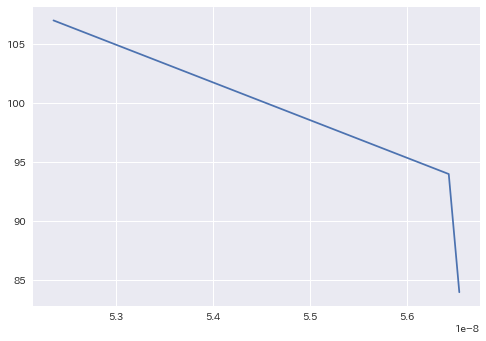

In [68]:
lines,  = plt.plot(df['一人当たり実質GDP(10^6yen)'] / df['18歳以上74歳以下免許取得者(人)'], df['自家用乗用車CO2排出量(10^6t)'])
# plt.setp(lines, title='一人当たり実質GDP(10^6yen)')

In [1]:
# lines,  = plt.bar(df['一人当たり実質GDP(10^6yen)'] / df['18歳以上74歳以下免許取得者(人)'], df['自家用乗用車CO2排出量(10^6t)'])
# plt.setp(lines, title='一人当たり実質GDP(10^6yen)')